In [49]:
from collections import defaultdict
import pandas as pd
from tools import load_pickle, clean_df
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr
import numpy as np

%matplotlib inline

In [27]:
def have4time(index_list):
    """determine whether left & right both meet the requirement. Also, two datestamps are required"""
    container = defaultdict(list)
    result = []
    for index in index_list:
        name = index.split('Date')[0]
        container[name].append(index)
        if len(container[name]) == 4:
            result.extend(container[name])
    return result

In [32]:
def split_pipe(data, selected_feature, key='original_shape_Volume'):
    data = data.sort_index()
    split_left = data.iloc[::2,:]
    split_right = data.iloc[1::2,:]
    x_left, y_left = clean_df(split_left, selected_feature, key)
    x_right, y_right = clean_df(split_right, selected_feature, key)
    return x_left, y_left, x_right, y_right

In [80]:
def read_bi_pipe(p=r'data/ago_bi.xlsx', 
                 pkl_p='data/selected_feature.pkl', key='original_shape_Volume'):
    split_data_temp = pd.read_excel(p)
    # the following step may casue the loss of data integrity, 'have4time' can make sure data is intact
    split_data = split_data_temp.loc[split_data_temp[key]>2000]
    sel_split_temp = split_data.loc[have4time(split_data.index.tolist())]
    selected_feature = load_pickle(pkl_p)
    x_left, y_left, x_right, y_right = split_pipe(sel_split_temp, selected_feature, key=key)
    return x_left, y_left, x_right, y_right

In [81]:
x_left, y_left, x_right, y_right = read_bi_pipe()

(21, 6)
(21, 6)


In [82]:
def y_creator(ori_y_p, sel):
    y = pd.read_excel(ori_y_p, index_col=0)
    y.index = y.index.astype(str)
    y_ori = y.loc[sel,:]
    return y_ori

In [83]:
y_ori = y_creator('data/y.xlsx', x_left.index)

In [36]:
def consistent_test(y, y_left, y_right):
    v_bind = y_left.iloc[:, :2] + y_right.iloc[:, :2]
    gap = abs(v_bind - y.iloc[:, :2]) / y.iloc[:, :2]
    return gap

In [84]:
ct_outcome = consistent_test(y_ori, y_left, y_right)

In [85]:
ct_outcome

,volume before,volume after
id,,
421451,0.004264,0.000207
609527,0.000752,0.002761
646881,0.013219,0.003955
654044,0.010833,0.014085
669403,0.003115,0.006778
681921,0.027457,0.026230
693985,0.007353,0.005771
697274,0.017316,0.019481
698060,0.000954,0.000320


In [86]:
def pie_helper(over_same, large_dominate):
    amount = len(over_same)
    num_same = sum(over_same)
    num_diff = amount - num_same
    num_ds = amount - sum(large_dominate)
    num_dl = num_diff -num_ds
    print(f"""Different Outcomes and Dominated by Large Part {num_dl},
         Different Outcomes and Dominated by Small Part,{num_ds},
         Same Outcomes: {num_same}""")

In [87]:
def trait_extract(y, y_left, y_right):
    """compute the realationship between bilateral parts and the whole brain"""
    left_same = y_left['effectiveness'] == y['effectiveness']
    right_same = y_right['effectiveness'] == y['effectiveness']
    over_same = left_same == right_same
    # test the trend consistence
    lr_same = y_left['effectiveness'] == y_right['effectiveness']
    assert sum(lr_same==over_same)/len(over_same) == 1, "Please Check the data, it is not consistent"
    left_large = y_left['volume before'] > y_right['volume before']
    left_dominate = left_large == left_same
    # when the right and the left are different, whelther the larger one play a more important role
    large_dominate = over_same | left_dominate
    df = pd.DataFrame({'over_same':over_same, 'fit_left':left_same, 'fit_right':right_same, 'large_dominate':large_dominate})
    pie_helper(over_same, large_dominate)
    return df

In [88]:
comparison = trait_extract(y_ori, y_left, y_right)

Different Outcomes and Dominated by Large Part 7,
         Different Outcomes and Dominated by Small Part,1,
         Same Outcomes: 13


In [89]:
def ingroup_distance(g1, g2, c):
    return abs(g1 - g2).values.tolist()

In [90]:
def outitem_distance(g1_sum, g2_sum, g1_len, g2_len, item):
    return  abs(g1_sum - item * g1_len) + abs(g2_sum - item * g2_len)

In [91]:
def outgroup_distance(g1, g2, c):
    g1_sum, g2_sum, g1_len, g2_len = sum(g1), sum(g2), len(g1), len(g2)
    return [(outitem_distance(g1_sum, g2_sum, g1_len, g2_len, item1) + \
             outitem_distance(g1_sum, g2_sum, g1_len, g2_len, item2)) / (2 * (g1_len + g2_len - 2))
            for item1, item2 in zip(g1, g2)]

In [92]:
def distance_pipe(df1, df2):
    recoder = {}
    for c in df1.columns:
        g1 = df1[c]
        g2 = df2[c]
        ingroup = ingroup_distance(g1, g2, c)
        outgroup = outgroup_distance(g1, g2, c)
        recoder[c] = (ingroup, outgroup)
    return recoder

In [93]:
def distance_plot(distance_recoder):
    fig, axes = plt.subplots(2, 3,figsize=(15,8))
    axes_f = axes.flatten()
    for idx, (k, v) in enumerate(distance_recoder.items()):
        ax = axes_f[idx]
        ingroup = v[0]
        outgroup = v[1]
        
        sns.distplot(ingroup, ax = ax, label='in One Patient')
        sns.distplot(outgroup, ax = ax, label='in Different Patient')
        ax.set_title(k)
        p = ttest_ind(ingroup, outgroup)[1]
        ax.text(0.76, 0.15, "p-value = {:.4f}".format(p), horizontalalignment='center',
            verticalalignment='center',transform = ax.transAxes, fontsize="medium")
#         ax.set_xlabel('Distence of Radiomics Image Features')
#         ax.set_ylabel('Density')

        ax.legend()
#     plt.text(-5.5, -1, 'Absoulte Difference', fontsize="medium")
#     plt.text(-14, 5.5, 'Density', fontsize="medium", rotation=90)
#     plt.savefig(name, dpi=300, bbox_inches="tight")

In [94]:
distance_recoder = distance_pipe(x_left, x_right)

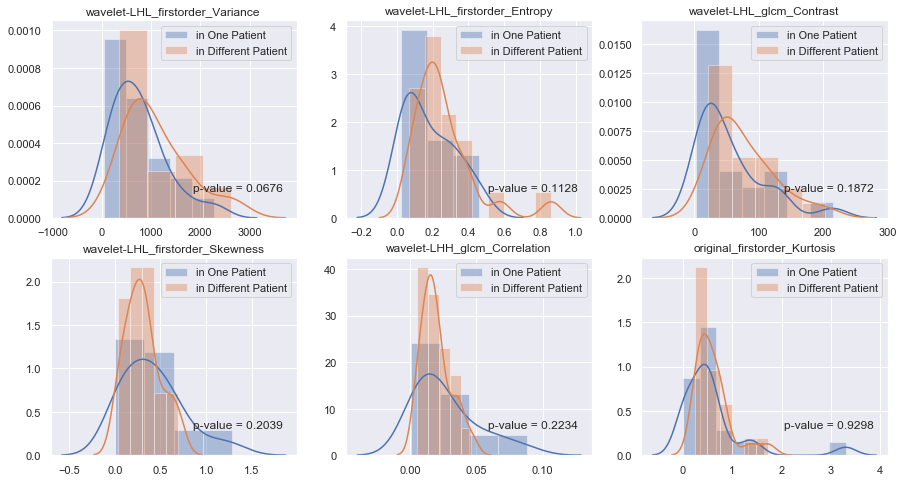

In [95]:
distance_plot(distance_recoder)

In [96]:
def plot_bi(df_set):
    sns.set()
    fig, axes = plt.subplots(6, 2,figsize=(8,24))
    axes_f = axes.flatten()
    archive = [{},{}]
    for j, dfs in enumerate(df_set):
        left = dfs[0]
        right = dfs[1]
        xs = left
        ys = right
        
        for i, c in enumerate(xs.columns):
            x = xs[c]
            y = ys[c]
            archive[j][c] = list(pearsonr(x, y))
            
            if j == 0:
                ax = axes_f[i*2]
            else:
                ax = axes_f[i*2 + 1]
            ax.scatter(x, y)

            ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),":" )
            correlation = np.corrcoef(x, y)[0,1]
            rsq = correlation ** 2

            ax.text(0.67, 0.1, "    $R^2$ = {:.4f}".format(rsq), horizontalalignment='center',
            verticalalignment='center',transform = ax.transAxes, fontsize="x-small")

            ax.set(xlabel="LEFT" , ylabel='RIGHT')
            ax.set_title(c)
    plt.text(0.33, 35.5, 'Same Outcomes', fontsize="large")
    plt.text(2.43, 35.5, 'Different Outcomes', fontsize="large")
    fig.tight_layout()
#     plt.savefig('bi_outcome.png', dpi=300, bbox_inches="tight")
    return archive

In [97]:
def corr_bi_pipe(comparison, x_left, x_right):
    same = comparison.loc[comparison['over_same'] == True].index
    different = comparison.loc[comparison['over_same'] != True].index
    df_set = ((x_left.loc[same], x_right.loc[same]), (x_left.loc[different], x_right.loc[different]))
    plot_bi(df_set)

D:\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


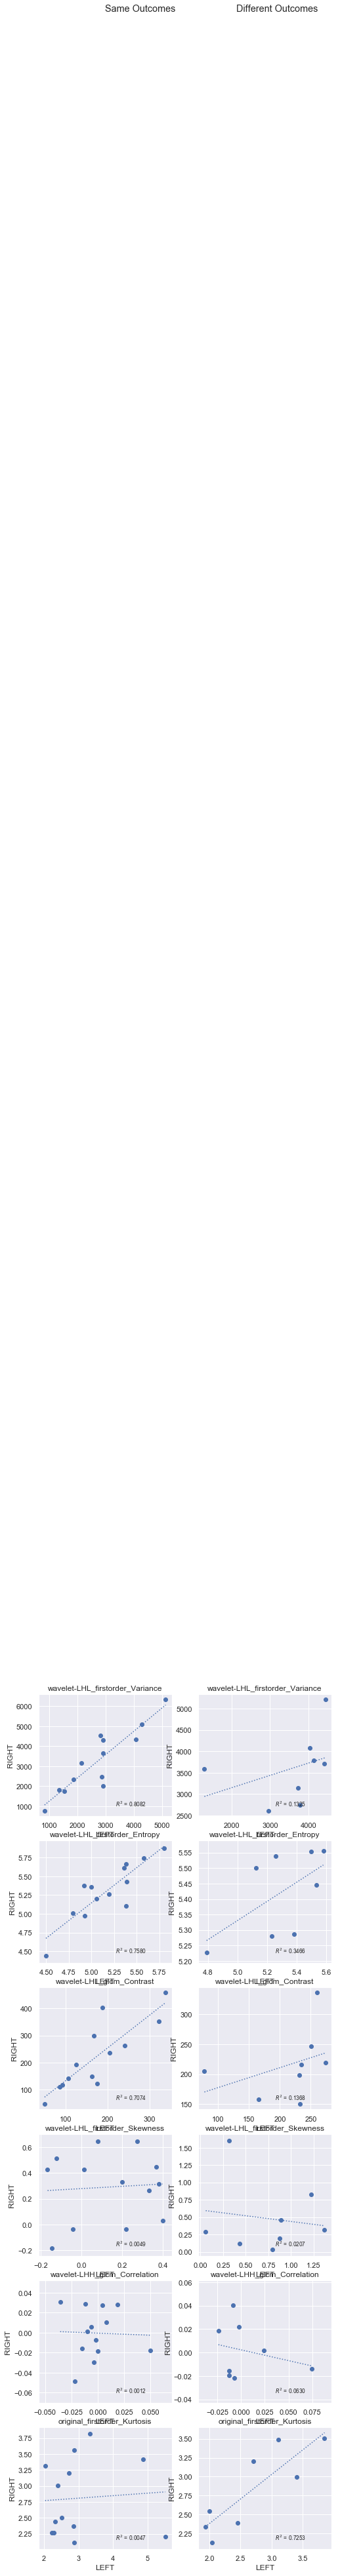

In [98]:
corr_bi_pipe(comparison, x_left, x_right)

x_lefta, y_lefta, x_righta, y_righta = read_bi_pipe('data/ago_bi.xlsx', key='original_shape_Volume')

y_la = y_left.loc[y_lefta.index]
y_ra = y_right.loc[y_righta.index]

""""someone provided me another data from the previous version""""
y_lefta + y_righta == y_la + y_ra

distance_plot(distance_pipe(x_lefta, x_righta))

y_ago = y_ori.loc[y_lefta.index] 

comparison_ago = trait_extract(y_ago, y_lefta, y_righta)
corr_bi_pipe(comparison_ago, x_lefta, x_righta)